

```
# author: puru panta (purupanta@uky.edu)
# date: 11/30/2024
# filename: PredictMLDL_Separate
```



In [1]:
!pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00


**STEP1: Load google-drive, and libraries**

In [2]:
# Mounting google drive if it is already not mounted
def LoadGoogleDrive(googleDriveDir):
  # Link Google Drive
  import os
  # Check if Google Drive is already mounted
  if not os.path.exists(googleDriveDir + "/MyDrive"):
      print("Mounting Google Drive...")
      from google.colab import drive
      drive.mount(googleDriveDir)
  else:
      print("Google Drive is already mounted!")

from google.colab import drive
googleDriveFolder = "/content/drive"
LoadGoogleDrive(googleDriveFolder)

Mounting Google Drive...
Mounted at /content/drive


In [4]:
import sys
import import_ipynb

# 1. Set path to the directory where mylib.ipynb is located
lib_path = '/content/drive/MyDrive/Colab Notebooks/P_HINTS6/lib'
sys.path.append(lib_path)
# 2. Change current working directory to that path
%cd "$lib_path"

# 3. Now import the notebook
from app_lib import *


/content/drive/MyDrive/Colab Notebooks/P_HINTS6/lib


**STEP2: Load data**

In [5]:
ip_file_path = googleDriveFolder + "/MyDrive/Colab Notebooks/P_HINTS6/op_data/hints6_public_filtered_v2.xlsx"
ip_sheet_name = 'df_cleaned'
df_orig = load_data(verbose_level=1, ip_file_path=ip_file_path, ip_sheet_name=ip_sheet_name)

Ip File Path: /content/drive/MyDrive/Colab Notebooks/P_HINTS6/op_data/hints6_public_filtered_v2.xlsx
 SheetName: df_cleaned
df_orig.shape: (4865, 27)


In [6]:
df = df_orig.copy()

In [7]:
# Quick overview
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4865 entries, 0 to 4864
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FreqGoProvider                 4865 non-null   int64  
 1   Deaf                           4865 non-null   int64  
 2   MedConditions_Diabetes         4865 non-null   int64  
 3   MedConditions_HighBP           4865 non-null   int64  
 4   MedConditions_HeartCondition   4865 non-null   int64  
 5   MedConditions_LungDisease      4865 non-null   int64  
 6   MedConditions_Depression       4865 non-null   int64  
 7   AverageSleepNight              4865 non-null   int64  
 8   AverageTimeSitting             4865 non-null   int64  
 9   EverHadCancer                  4865 non-null   int64  
 10  Age                            4865 non-null   int64  
 11  BirthGender                    4865 non-null   int64  
 12  BMI                            4865 non-null   f

In [8]:
# Basic summary statistics
summary_stats = df.describe().T

# Identify binary columns (only 0 and 1, ignoring NaNs)
binary_columns = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

# Count of 1s and 0s in binary columns
binary_one_counts = df[binary_columns].sum().rename("Count of 1s")
binary_zero_counts = (df[binary_columns] == 0).sum().rename("Count of 0s")
binary_total_counts = (binary_one_counts + binary_zero_counts).rename("Count of 0s + 1s")

# Combine all together
combined_summary = (
    summary_stats
    .join(binary_one_counts, how='left')
    .join(binary_zero_counts, how='left')
    .join(binary_total_counts, how='left')
)

# Optional: style for display in notebooks
styled_summary = combined_summary.style.format(precision=3).set_properties(**{
    'text-align': 'left',
    'font-family': 'Arial',
    'border': '1px solid lightgray'
}).set_caption("Feature Summary Statistics with Binary Counts")

# Optional: to display in notebook
display(styled_summary)

# Export to Excel
op_file_path = googleDriveFolder + "/MyDrive/Colab Notebooks/P_HINTS6/op_data/summary_statistics.xlsx"
sheet_name = 'summary_statistics'
styled_summary.to_excel(op_file_path, sheet_name=sheet_name, engine="openpyxl")


,count,mean,std,min,25%,50%,75%,max,Count of 1s,Count of 0s,Count of 0s + 1s
FreqGoProvider,4865.000,2.959,1.839,0.000,1.000,3.000,5.000,6.000,nan,nan,nan
Deaf,4865.000,0.087,0.282,0.000,0.000,0.000,0.000,1.000,425.000,4440.000,4865.000
MedConditions_Diabetes,4865.000,0.199,0.399,0.000,0.000,0.000,0.000,1.000,969.000,3896.000,4865.000
MedConditions_HighBP,4865.000,0.432,0.495,0.000,0.000,0.000,1.000,1.000,2101.000,2764.000,4865.000
MedConditions_HeartCondition,4865.000,0.093,0.291,0.000,0.000,0.000,0.000,1.000,453.000,4412.000,4865.000
MedConditions_LungDisease,4865.000,0.135,0.342,0.000,0.000,0.000,0.000,1.000,656.000,4209.000,4865.000
MedConditions_Depression,4865.000,0.270,0.444,0.000,0.000,0.000,1.000,1.000,1314.000,3551.000,4865.000
AverageSleepNight,4865.000,6.908,1.404,0.000,6.000,7.000,8.000,24.000,nan,nan,nan
AverageTimeSitting,4865.000,6.814,3.575,0.000,4.000,6.000,9.000,20.000,nan,nan,nan
EverHadCancer,4865.000,0.149,0.356,0.000,0.000,0.000,0.000,1.000,723.000,4142.000,4865.000


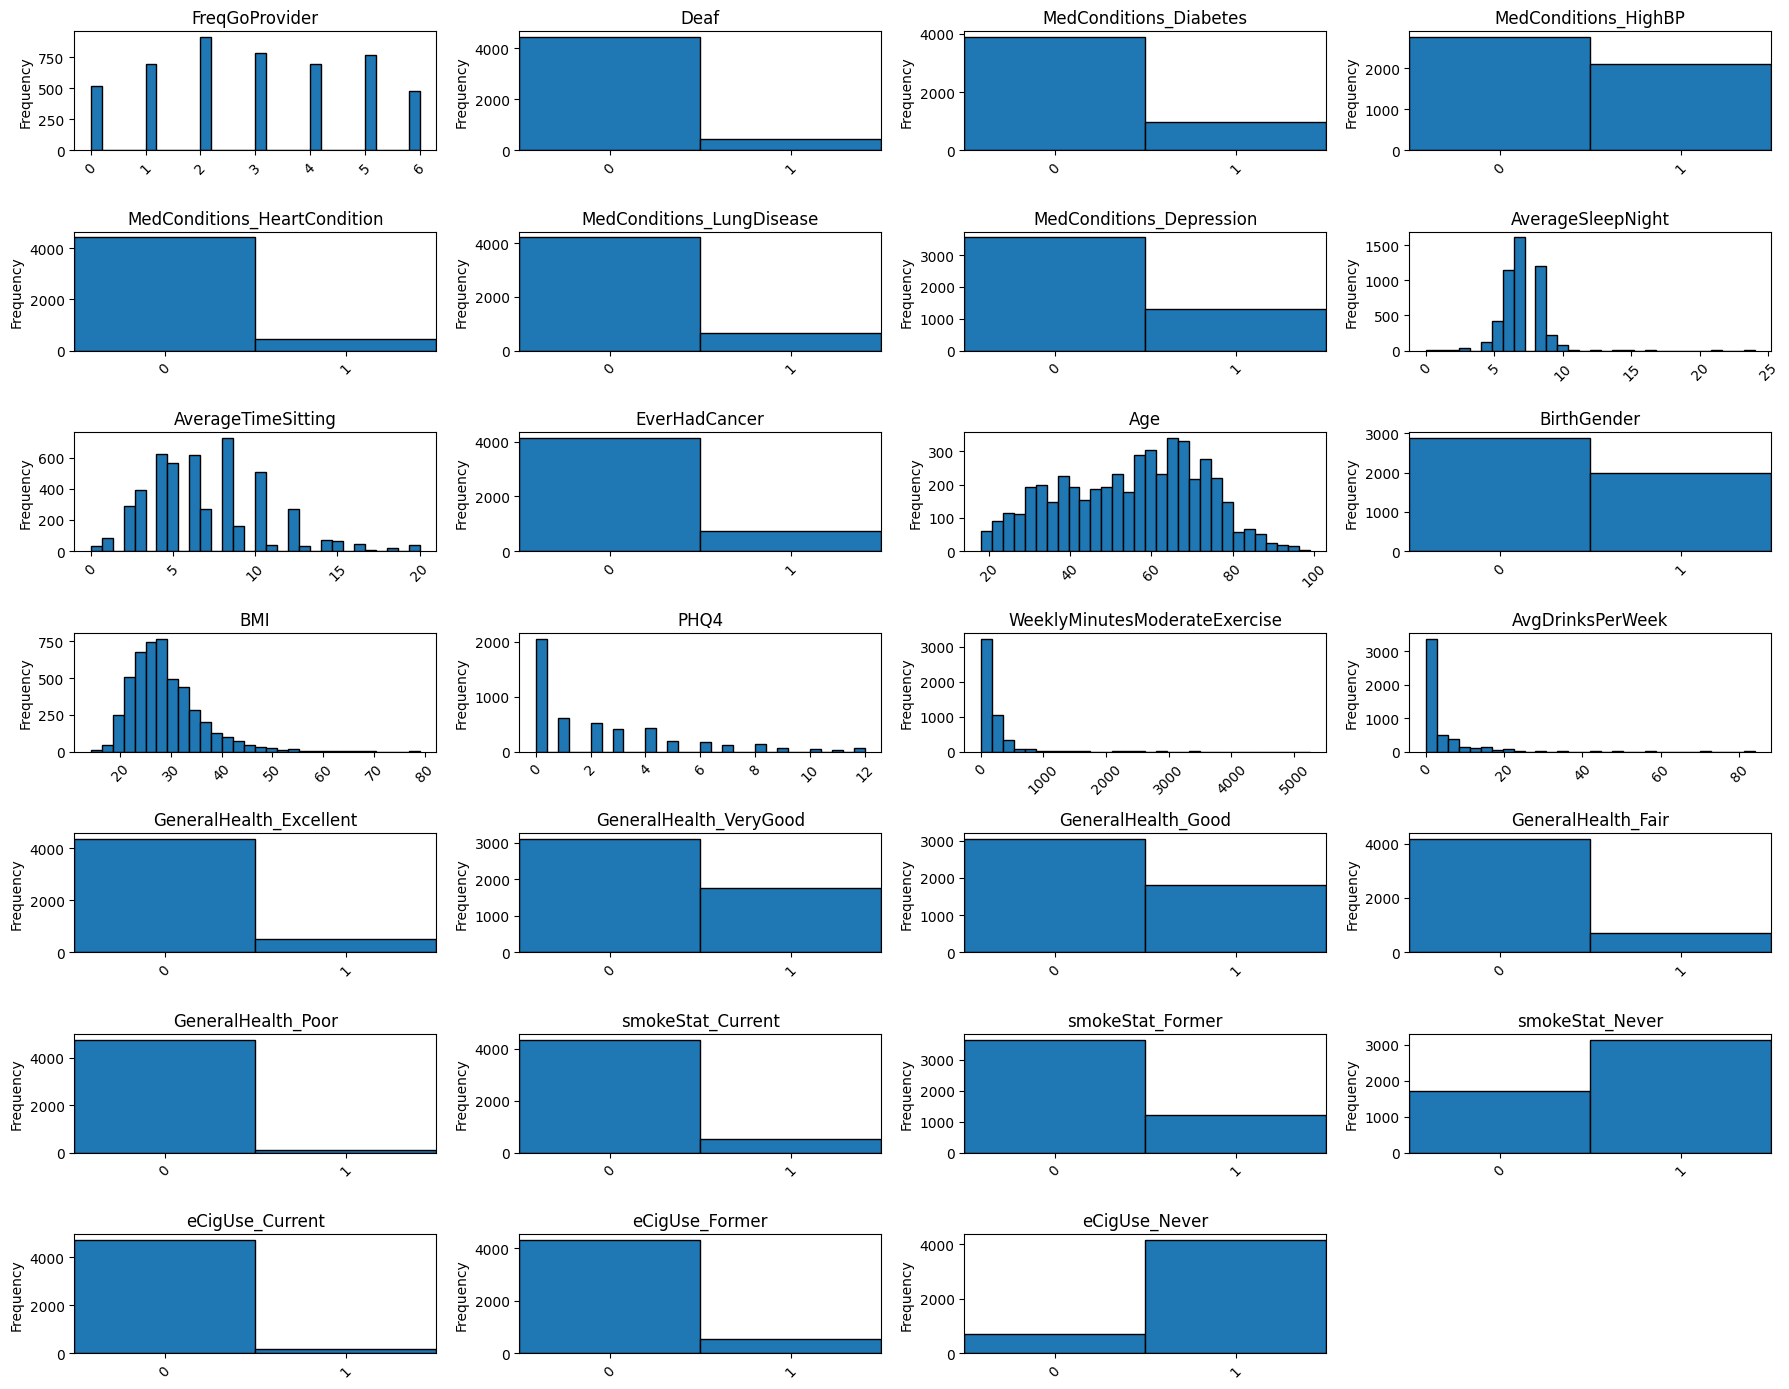

In [9]:
import matplotlib.pyplot as plt

# Identify binary columns (0 and 1 only, ignoring NaNs)
binary_columns = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

# Create subplot grid
fig, axes = plt.subplots(nrows=(len(df.columns) + 3) // 4, ncols=4, figsize=(18, 14))
axes = axes.flatten()

# Plot each column individually
for i, col in enumerate(df.columns):
    ax = axes[i]
    if col in binary_columns:
        # Exact bins for 0 and 1, no gap
        df[col].plot.hist(ax=ax, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=1)
        ax.set_xticks([0, 1])
        ax.set_xlim(-0.5, 1.5)
    else:
        # Continuous: tighter bars with rwidth=1 for no space
        df[col].plot.hist(ax=ax, bins=30, edgecolor='black', rwidth=1)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


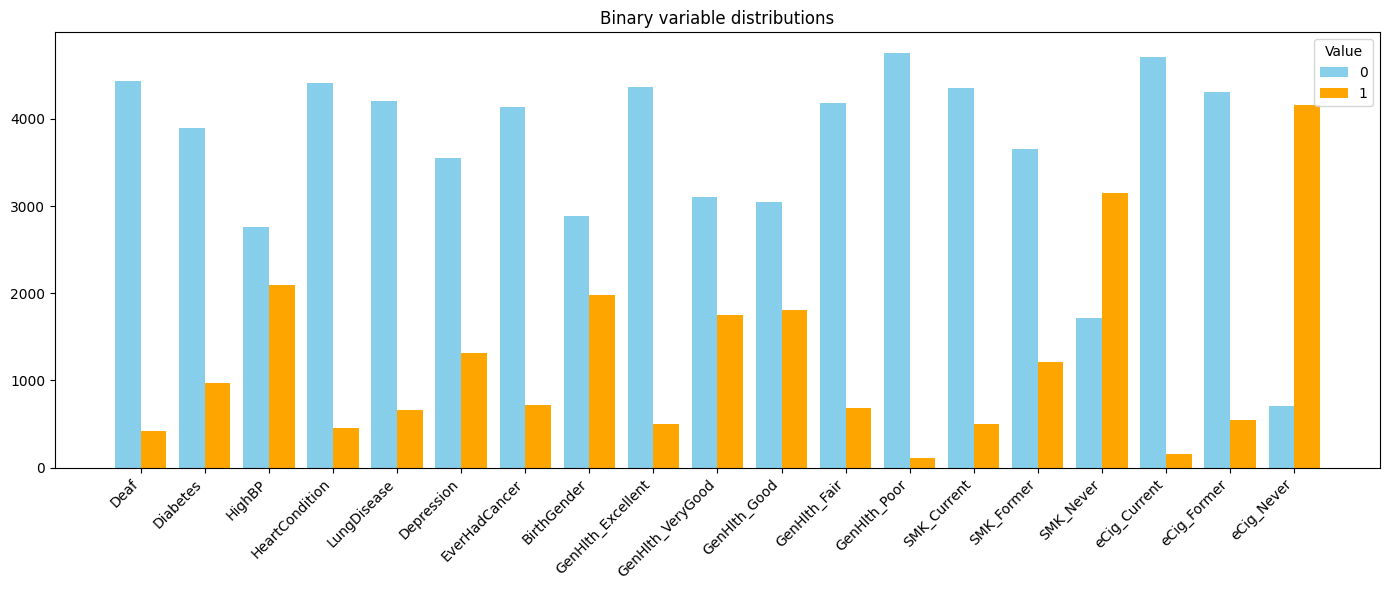

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify binary columns (0 and 1 only)
binary_columns = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

# Relabel columns according to your mapping rules
def relabel(col):
    col = col.replace("MedConditions_", "")
    col = col.replace("GeneralHealth_", "GenHlth_")
    col = col.replace("smokeStat_", "SMK_")
    col = col.replace("eCigUse_", "eCig_")
    return col

renamed_labels = [relabel(col) for col in binary_columns]

# Count 0s and 1s
binary_counts = pd.DataFrame({
    '0': [(df[col] == 0).sum() for col in binary_columns],
    '1': [(df[col] == 1).sum() for col in binary_columns]
}, index=renamed_labels)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(renamed_labels))
bar_width = 0.4

ax.bar([i - bar_width/2 for i in x], binary_counts['0'], width=bar_width, label='0', color='skyblue')
ax.bar([i + bar_width/2 for i in x], binary_counts['1'], width=bar_width, label='1', color='orange')

# Axis formatting
ax.set_xticks(x)
ax.set_xticklabels(renamed_labels, rotation=45, ha='right')
# ax.set_ylabel("Count")
ax.set_title("Binary variable distributions")
ax.legend(title="Value", loc='upper right')

plt.tight_layout()
plt.show()


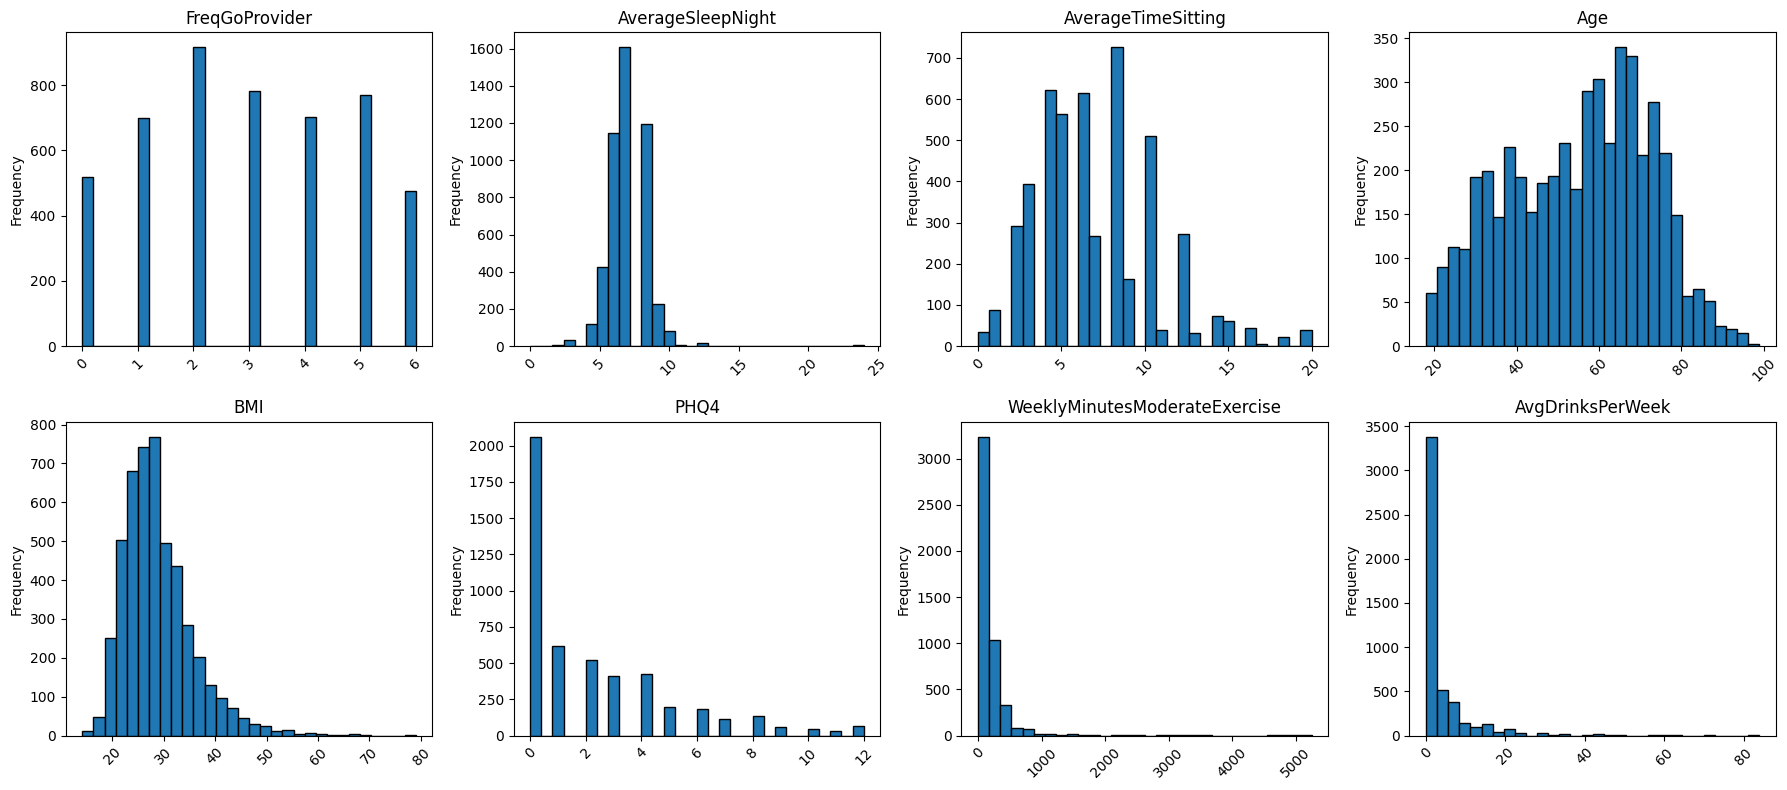

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify binary columns (only 0 or 1)
binary_columns = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]
non_binary_columns = [col for col in df.columns if col not in binary_columns]

# Create subplot grid for non-binary columns
ncols = 4
nrows = (len(non_binary_columns) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

# Plot each non-binary column
for i, col in enumerate(non_binary_columns):
    ax = axes[i]
    df[col].plot.hist(
        ax=ax,
        bins=30,
        edgecolor='black',
        rwidth=1.0
    )
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


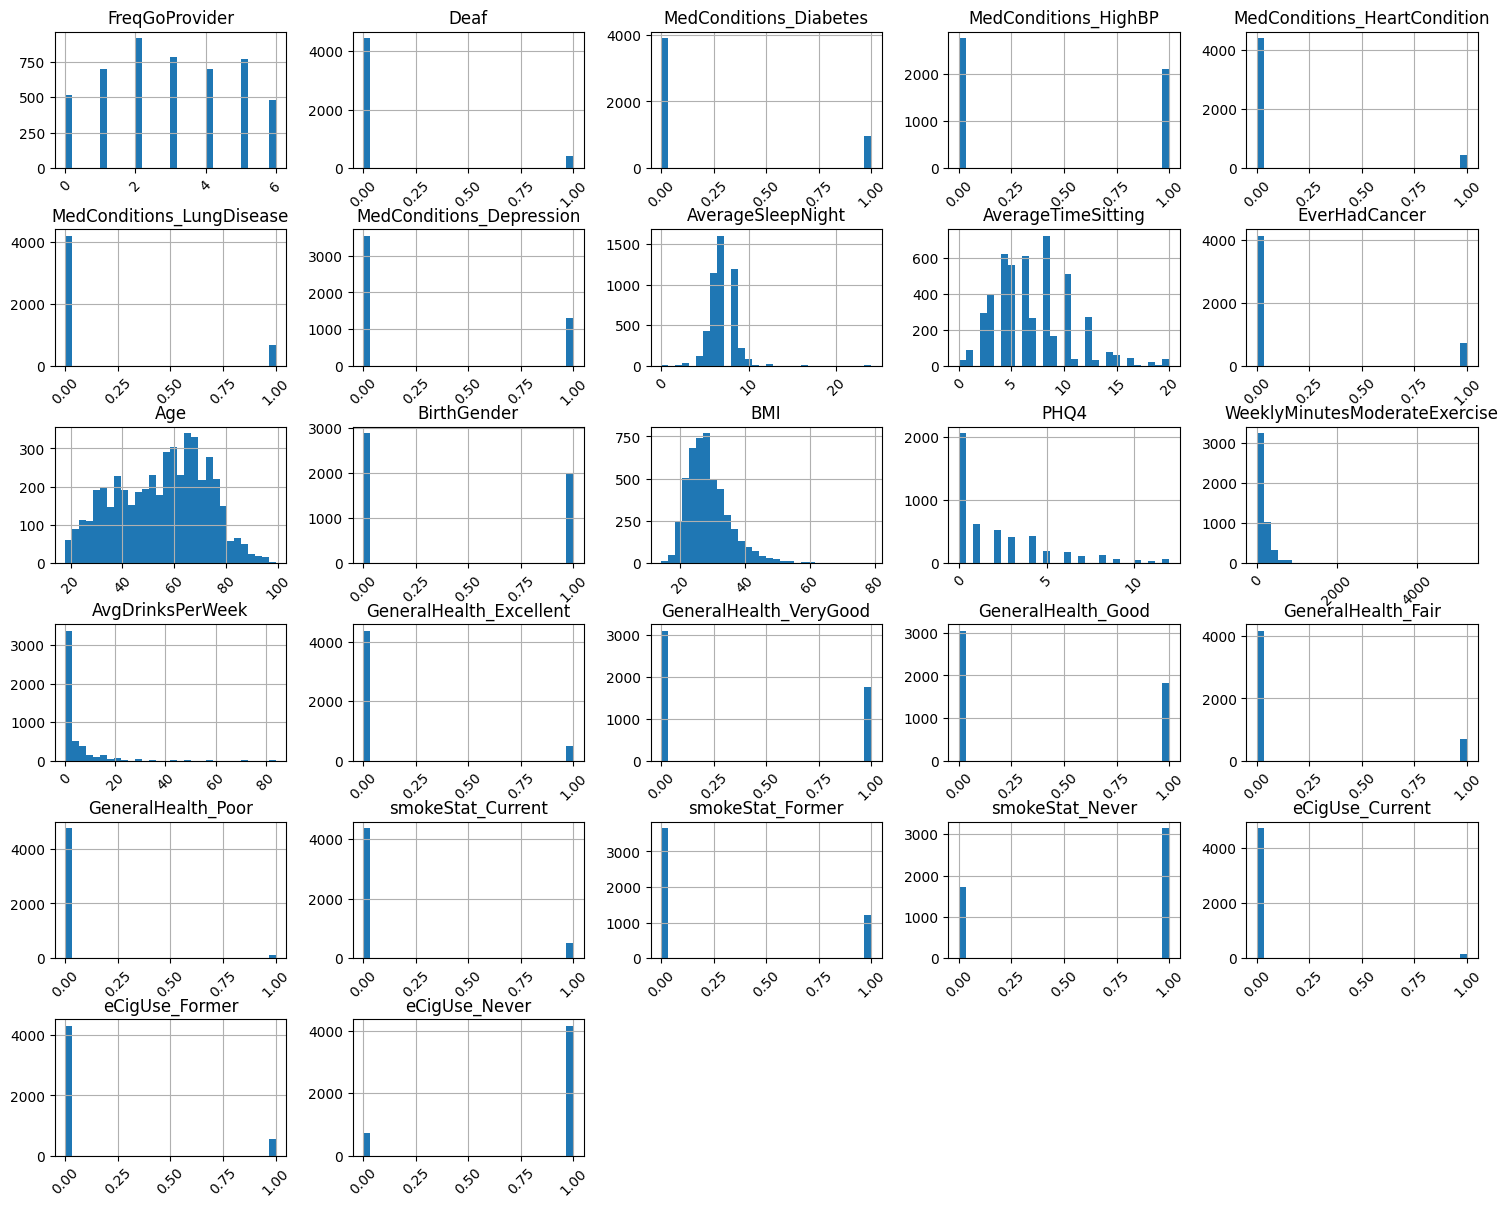

In [12]:
import matplotlib.pyplot as plt

ax = df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()  # Adjusts spacing automatically

# Optional: rotate x-axis labels for all plots
for a in ax.flatten():
    for label in a.get_xticklabels():
        label.set_rotation(45)


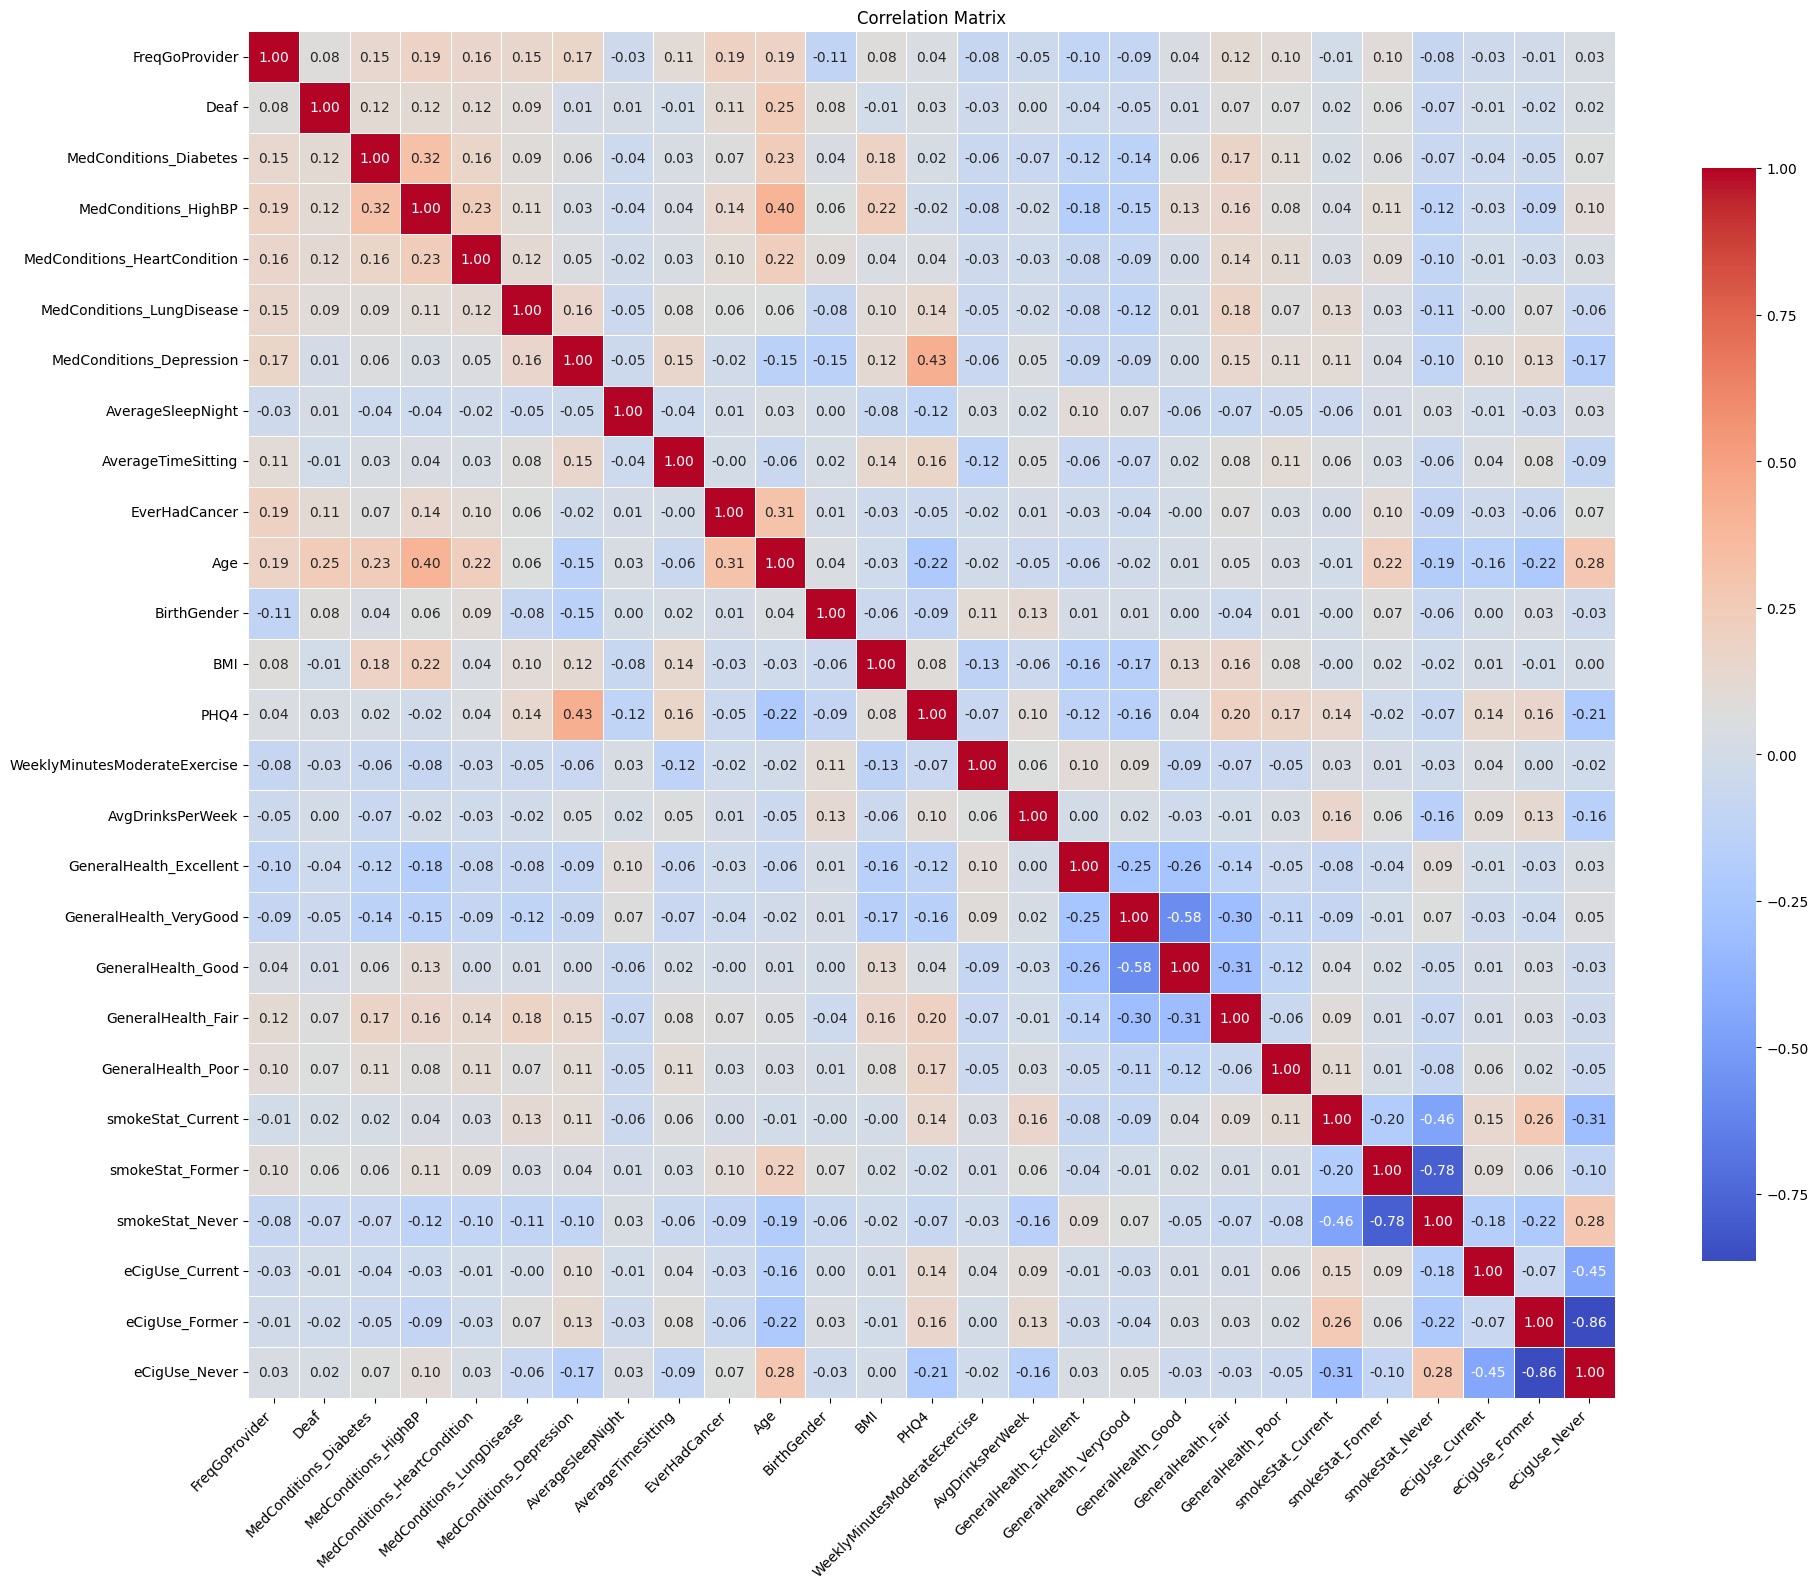

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Compute the correlation matrix (numeric columns only)
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-897246110.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=target_corr[target], y=target_corr.index, palette='coolwarm')


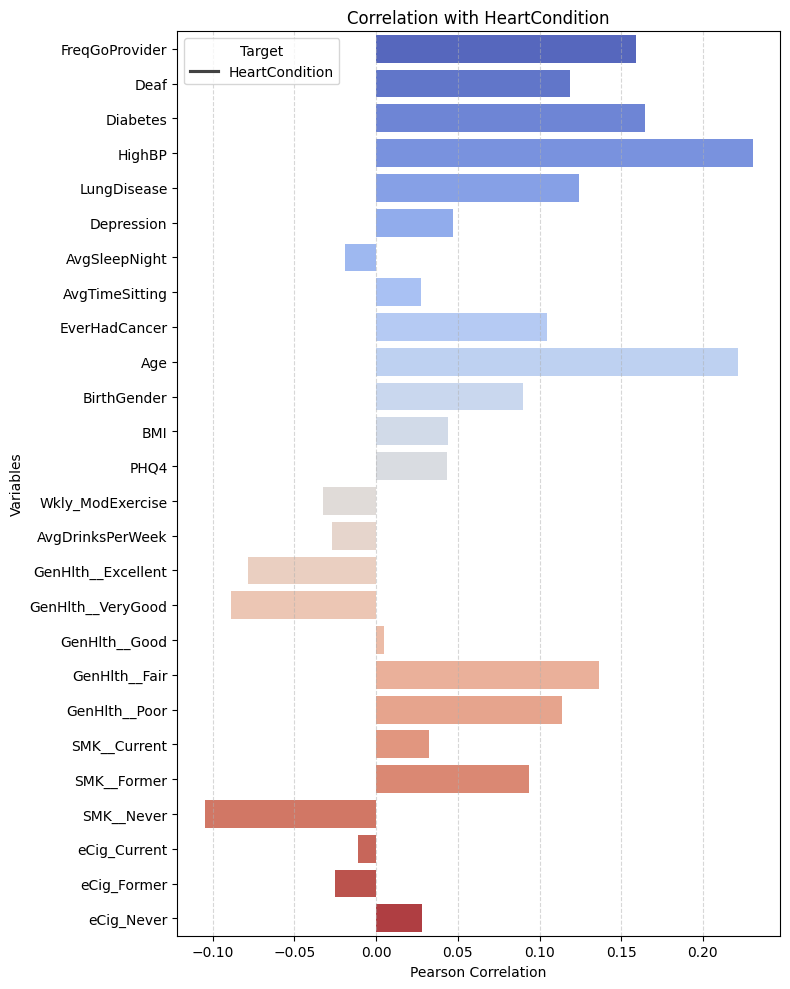

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Target variable
target = 'MedConditions_HeartCondition'

# Select numeric columns only
numeric_df = df.select_dtypes(include='number')

# Ensure target is in the data
if target not in numeric_df.columns:
    raise ValueError(f"Target column '{target}' not found in numeric columns.")

# Compute correlation with the target
target_corr = numeric_df.corr()[[target]].drop(index=target)

# Function to shorten variable names
def shorten(name):
    name = name.replace("MedConditions_", "")
    name = name.replace("GeneralHealth", "GenHlth_")
    name = name.replace("smokeStat", "SMK_")
    name = name.replace("eCigUse", "eCig")
    name = name.replace("WeeklyMinutesModerateExercise", "Wkly_ModExercise")
    name = name.replace("Average", "Avg")
    return name

# Apply short names to y-axis labels
target_corr.index = [shorten(col) for col in target_corr.index]

# Plot
plt.figure(figsize=(8, 10))
bars = sns.barplot(x=target_corr[target], y=target_corr.index, palette='coolwarm')

# Manual legend in top-left corner
plt.legend([shorten(target)], title='Target', loc='upper left')

plt.title(f"Correlation with {shorten(target)}")
plt.xlabel("Pearson Correlation")
plt.ylabel("Variables")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3911294514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=target_corr_sorted[target], y=target_corr_sorted.index, palette='coolwarm')


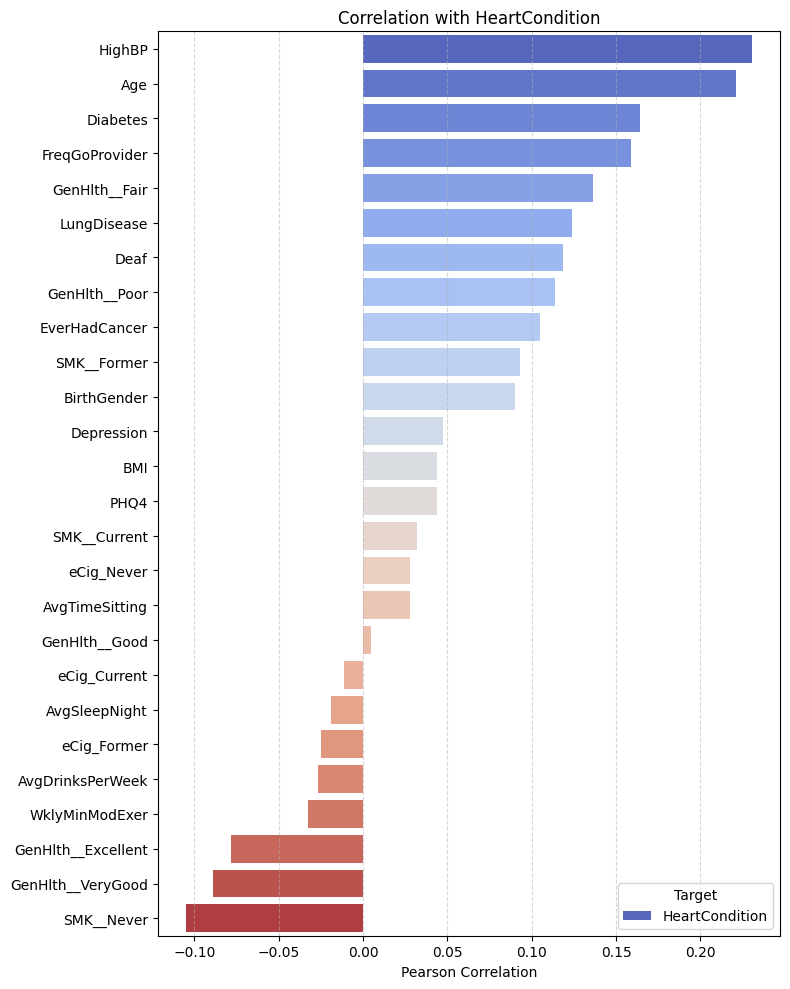

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable
target = 'MedConditions_HeartCondition'

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Ensure target is present
if target not in numeric_df.columns:
    raise ValueError(f"Target column '{target}' not found in numeric columns.")

# Compute correlation of features with target
target_corr = numeric_df.corr()[[target]].drop(index=target)

# Relabeling function for short names
def shorten(name):
    name = name.replace("MedConditions_", "")
    name = name.replace("GeneralHealth", "GenHlth_")
    name = name.replace("smokeStat", "SMK_")
    name = name.replace("eCigUse", "eCig")
    name = name.replace("Average", "Avg")
    name = name.replace("WeeklyMinutesModerateExercise", "WklyMinModExer")
    return name

# Apply short names to y-axis
target_corr.index = [shorten(col) for col in target_corr.index]

# Sort correlations: highest positive at top, negative at bottom
target_corr_sorted = target_corr.sort_values(by=target, ascending=False)

# Plot
plt.figure(figsize=(8, 10))
bars = sns.barplot(x=target_corr_sorted[target], y=target_corr_sorted.index, palette='coolwarm')

# Add legend manually
plt.legend(bars.containers, [shorten(target)], title='Target', loc='lower right')

plt.title(f"Correlation with {shorten(target)}")
plt.xlabel("Pearson Correlation")
plt.ylabel("")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'FreqGoProvider'),
  Text(1, 0, 'Deaf'),
  Text(2, 0, 'MedConditions_Diabetes'),
  Text(3, 0, 'MedConditions_HighBP'),
  Text(4, 0, 'MedConditions_HeartCondition'),
  Text(5, 0, 'MedConditions_LungDisease'),
  Text(6, 0, 'MedConditions_Depression'),
  Text(7, 0, 'AverageSleepNight'),
  Text(8, 0, 'AverageTimeSitting'),
  Text(9, 0, 'EverHadCancer'),
  Text(10, 0, 'Age'),
  Text(11, 0, 'BirthGender'),
  Text(12, 0, 'BMI'),
  Text(13, 0, 'PHQ4'),
  Text(14, 0, 'WeeklyMinutesModerateExercise'),
  Text(15, 0, 'AvgDrinksPerWeek'),
  Text(16, 0, 'GeneralHealth_Excellent'),
  Text(17, 0, 'GeneralHealth_VeryGood'),
  Text(18, 0, 'GeneralHealth_Good'),
  Text(19, 0, 'GeneralHealth_Fair'),
  Text(20, 0, 'GeneralHealth_Poor'),
  Text(21, 0, 'smokeStat_Current'),
  Text(22, 0, 'smokeStat_Former'),
  Text(23, 0, 'smokeStat_Never'),
  T

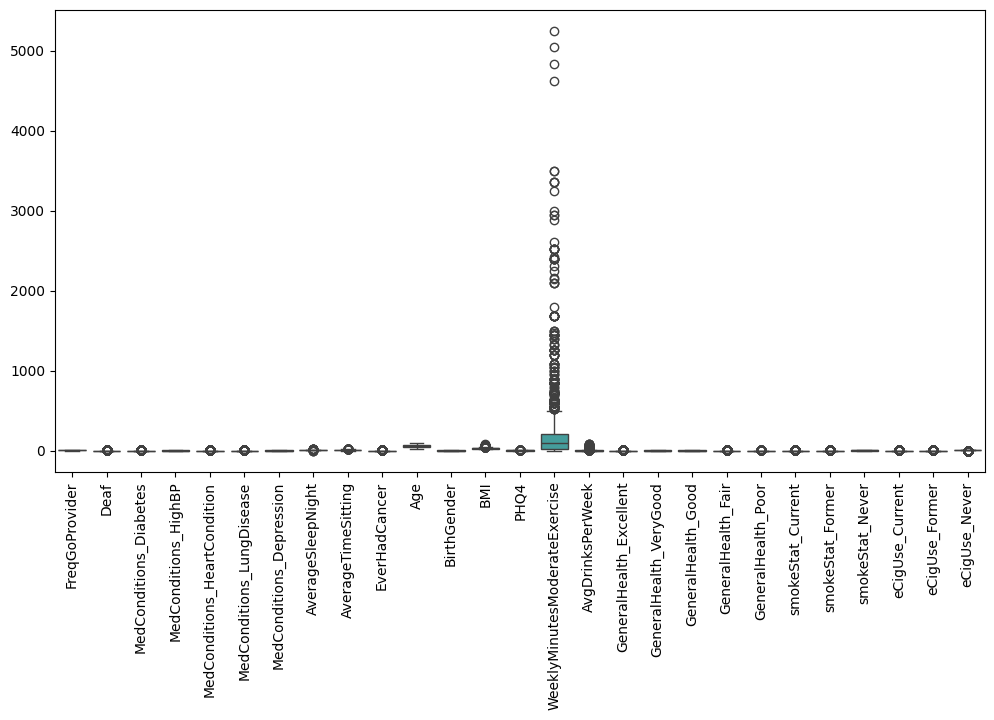

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)


In [17]:
sns.pairplot(df)


Output hidden; open in https://colab.research.google.com to view.

**STEP3: Train-Validation-Test split**

In [18]:
df = df_orig.copy()
# Set your target column name
target_col = 'MedConditions_HeartCondition'

# Split into features (X) and target (y)
X = df_orig.drop(columns=[target_col])
y = df_orig[target_col]

In [19]:
# Run preprocessing
verbose_level = 2
result = data_preprocessing(verbose_level, X, y)

# ➤ Scaled features (ready for model input)
X_train_res_scaled = result['X_train_res_scaled']
X_val_scaled = result['X_val_scaled']
X_test_scaled = result['X_test_scaled']

# ➤ Raw feature splits (before scaling)
X_train = result['X_train']              # original train split
X_train_res = result['X_train_res']      # SMOTE-balanced train
X_val = result['X_val']
X_test = result['X_test']

# ➤ Corresponding labels
y_train = result['y_train']              # before SMOTE
y_train_res = result['y_train_res']      # after SMOTE
y_val = result['y_val']
y_test = result['y_test']

# ➤ Feature names (for inspection, SHAP, etc.)
features = result['features']



Original data shape: (4865, 26)

Before SMOTE => (Train shape: (2919, 26)), (Validation shape: (973, 26)), (Test shape: (973, 26))
After SMOTE  => (Train shape: (5271, 26)), (Validation shape: (973, 26)), (Test shape: (973, 26))
After Scaling => (Train shape: (5271, 26)), (Validation shape: (973, 26)), (Test shape: (973, 26))


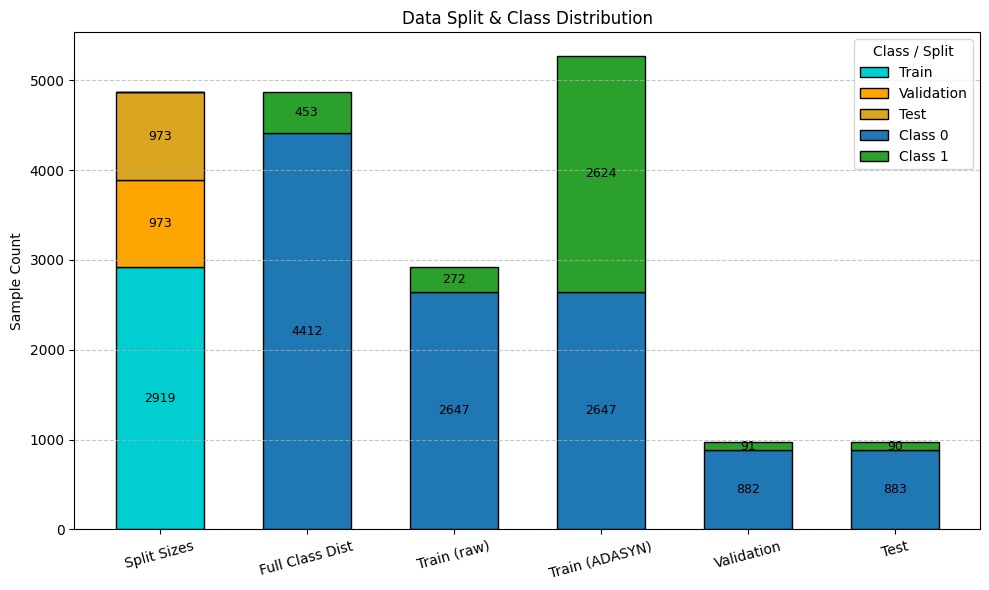

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Combine original labels (before/after ADASYN and splits)
y_total = pd.concat([y_train, y_val, y_test])  # full dataset

plot_data = {
    'Split Sizes': {
        'Train': len(y_train),
        'Validation': len(y_val),
        'Test': len(y_test)
    },
    'Full Class Dist': {
        'Class 0': (y_total == 0).sum(),
        'Class 1': (y_total == 1).sum()
    },
    'Train (raw)': {
        'Class 0': (y_train == 0).sum(),
        'Class 1': (y_train == 1).sum()
    },
    'Train (ADASYN)': {
        'Class 0': (y_train_res == 0).sum(),
        'Class 1': (y_train_res == 1).sum()
    },
    'Validation': {
        'Class 0': (y_val == 0).sum(),
        'Class 1': (y_val == 1).sum()
    },
    'Test': {
        'Class 0': (y_test == 0).sum(),
        'Class 1': (y_test == 1).sum()
    }
}

# Color palette
class_colors = {
    'Train': '#00CED1',
    'Validation': '#FFA500',
    'Test': '#DAA520',
    'Class 0': '#1f77b4',
    'Class 1': '#2ca02c'
}

# Build DataFrame
df_plot = pd.DataFrame(plot_data).T.fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df_plot.index))
bar_width = 0.6
bottom = np.zeros(len(x))

for cls in df_plot.columns:
    heights = df_plot[cls].values
    if np.all(heights == 0):
        continue

    ax.bar(
        x, heights, bottom=bottom, width=bar_width,
        label=cls, color=class_colors.get(cls, 'gray'), edgecolor='black'
    )

    # Annotate bars
    for i, height in enumerate(heights):
        if height > 0:
            ax.text(
                x[i], bottom[i] + height / 2, str(int(height)),
                ha='center', va='center', fontsize=9
            )

    bottom += heights

# Format
ax.set_xticks(x)
ax.set_xticklabels(df_plot.index, rotation=15)
ax.set_title('Data Split & Class Distribution')
ax.set_ylabel('Sample Count')
ax.legend(title='Class / Split', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


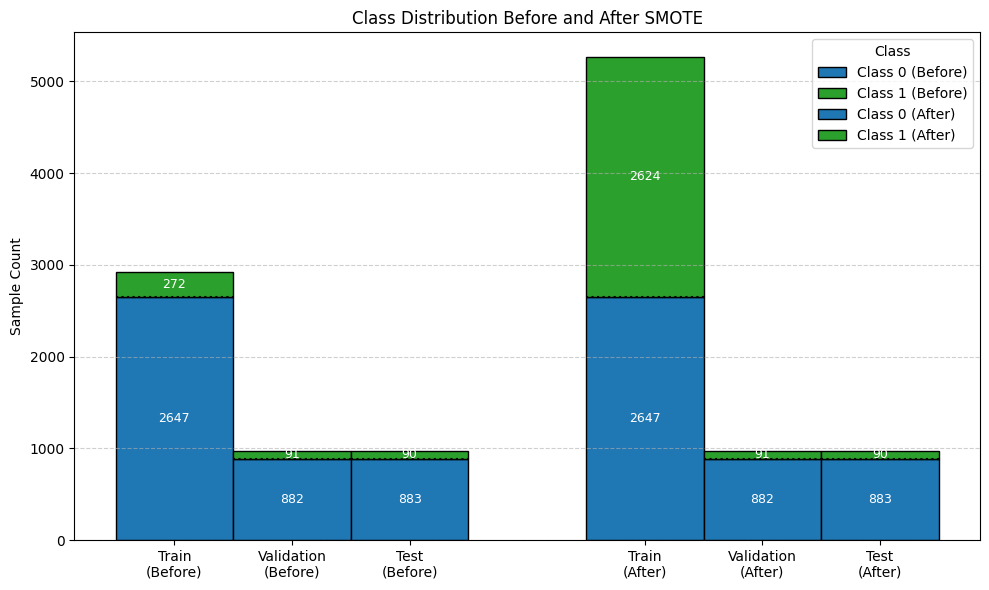

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Count class distributions
split_before = {
    'Train (raw)': {
        'Class 0': (y_train == 0).sum(),
        'Class 1': (y_train == 1).sum()
    },
    'Validation': {
        'Class 0': (y_val == 0).sum(),
        'Class 1': (y_val == 1).sum()
    },
    'Test': {
        'Class 0': (y_test == 0).sum(),
        'Class 1': (y_test == 1).sum()
    }
}

split_after = {
    'Train (SMOTE)': {
        'Class 0': (y_train_res == 0).sum(),
        'Class 1': (y_train_res == 1).sum()
    },
    'Validation': split_before['Validation'],
    'Test': split_before['Test']
}

# Create DataFrames
df_before = pd.DataFrame(split_before).T
df_after = pd.DataFrame(split_after).T

# Combine all labels and set x positions
labels = ['Train', 'Validation', 'Test']
x_before = np.arange(3)
x_after = x_before + 4  # space between groups

bar_width = 1.0
class_colors = {'Class 0': '#1f77b4', 'Class 1': '#2ca02c'}

fig, ax = plt.subplots(figsize=(10, 6))

# --- Plot before SMOTE ---
c0_before = df_before['Class 0'].values
c1_before = df_before['Class 1'].values

ax.bar(x_before, c0_before, width=bar_width,
       color=class_colors['Class 0'], edgecolor='black', label='Class 0 (Before)')
ax.bar(x_before, c1_before, bottom=c0_before, width=bar_width,
       color=class_colors['Class 1'], edgecolor='black', label='Class 1 (Before)')

# --- Plot after SMOTE ---
c0_after = df_after['Class 0'].values
c1_after = df_after['Class 1'].values

ax.bar(x_after, c0_after, width=bar_width,
       color=class_colors['Class 0'], edgecolor='black', label='Class 0 (After)')
ax.bar(x_after, c1_after, bottom=c0_after, width=bar_width,
       color=class_colors['Class 1'], edgecolor='black', label='Class 1 (After)')

# --- Add dotted lines and labels ---
def annotate_bars(x_pos, class0, class1):
    for i in range(len(x_pos)):
        ax.hlines(class0[i], x_pos[i] - bar_width/2, x_pos[i] + bar_width/2,
                  linestyle='dotted', color='black')
        ax.text(x_pos[i], class0[i] / 2, str(class0[i]), ha='center', va='center', color='white', fontsize=9)
        ax.text(x_pos[i], class0[i] + class1[i] / 2, str(class1[i]), ha='center', va='center', color='white', fontsize=9)

annotate_bars(x_before, c0_before, c1_before)
annotate_bars(x_after, c0_after, c1_after)

# --- Final formatting ---
all_xticks = np.concatenate([x_before, x_after])
all_labels = [f'{label}\n(Before)' for label in labels] + [f'{label}\n(After)' for label in labels]

ax.set_xticks(all_xticks)
ax.set_xticklabels(all_labels)
ax.set_ylabel("Sample Count")
ax.set_title("Class Distribution Before and After SMOTE")
ax.legend(title="Class")
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


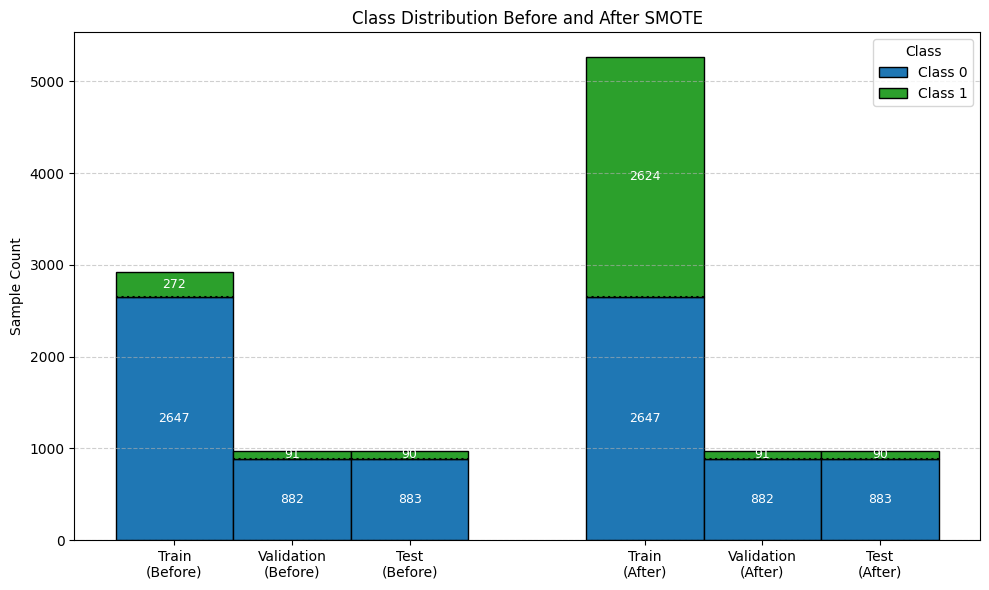

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Count class distributions
split_before = {
    'Train': {
        'Class 0': (y_train == 0).sum(),
        'Class 1': (y_train == 1).sum()
    },
    'Validation': {
        'Class 0': (y_val == 0).sum(),
        'Class 1': (y_val == 1).sum()
    },
    'Test': {
        'Class 0': (y_test == 0).sum(),
        'Class 1': (y_test == 1).sum()
    }
}

split_after = {
    'Train': {
        'Class 0': (y_train_res == 0).sum(),
        'Class 1': (y_train_res == 1).sum()
    },
    'Validation': split_before['Validation'],
    'Test': split_before['Test']
}

# Create DataFrames
df_before = pd.DataFrame(split_before).T
df_after = pd.DataFrame(split_after).T

# Bar positions
labels = ['Train', 'Validation', 'Test']
x_before = np.arange(3)
x_after = x_before + 4  # space between before and after group

bar_width = 1.0
class_colors = {'Class 0': '#1f77b4', 'Class 1': '#2ca02c'}

fig, ax = plt.subplots(figsize=(10, 6))

# --- Plot before SMOTE ---
c0_before = df_before['Class 0'].values
c1_before = df_before['Class 1'].values
ax.bar(x_before, c0_before, width=bar_width,
       color=class_colors['Class 0'], edgecolor='black')
ax.bar(x_before, c1_before, bottom=c0_before, width=bar_width,
       color=class_colors['Class 1'], edgecolor='black')

# --- Plot after SMOTE ---
c0_after = df_after['Class 0'].values
c1_after = df_after['Class 1'].values
ax.bar(x_after, c0_after, width=bar_width,
       color=class_colors['Class 0'], edgecolor='black', label='Class 0')
ax.bar(x_after, c1_after, bottom=c0_after, width=bar_width,
       color=class_colors['Class 1'], edgecolor='black', label='Class 1')

# --- Add dotted lines and labels ---
def annotate_bars(x_pos, class0, class1):
    for i in range(len(x_pos)):
        ax.hlines(class0[i], x_pos[i] - bar_width / 2, x_pos[i] + bar_width / 2,
                  linestyle='dotted', color='black')
        ax.text(x_pos[i], class0[i] / 2, str(class0[i]), ha='center', va='center', color='white', fontsize=9)
        ax.text(x_pos[i], class0[i] + class1[i] / 2, str(class1[i]), ha='center', va='center', color='white', fontsize=9)

annotate_bars(x_before, c0_before, c1_before)
annotate_bars(x_after, c0_after, c1_after)

# --- Final formatting ---
all_xticks = np.concatenate([x_before, x_after])
all_labels = [f'{label}\n(Before)' for label in labels] + [f'{label}\n(After)' for label in labels]

ax.set_xticks(all_xticks)
ax.set_xticklabels(all_labels)
ax.set_ylabel("Sample Count")
ax.set_title("Class Distribution Before and After SMOTE")
ax.legend(title="Class")
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
